# Classification
This file includes code which classifies text chunks as (Austen, Shelly, Kafka, Tolstoy or Dostoyevsky).
The training data is text chunks from their respective works 'Pride and predjudice', 'Frankenstein', 'The trial', 'Anna Karenina' and 'Crime and punishment'. We obtain the texts from the Gutenberg Project.

## Importing the data

In [11]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from textdataset import TextDataset
from neural_net import NeuralNet

In [ ]:
# Importing the transformer
from sentence_transformers import SentenceTransformer
model_name = "mixedbread-ai/mxbai-embed-large-v1" 
"""
Change the default model here. To save the model locally, replace the path with your path and run this module.
At the end of your path, add the name of the folder you want create for the model, eg. ".../local_model"
When you have downloaded the model, uncomment model_name = path to use the stored model.
"""
# path = "C:/Users/jonas/OneDrive/Dokumenter/Python Scripts/embed/local_model_sentence_transformers" # (example path / for my convenience)
# model_name = path # Uncomment this line once you have downloaded the model.
model = SentenceTransformer(model_name)

In [5]:
# Helpers
def preprocessing(filepath, text):
    if 'austen' in filepath:
        start = text.find("Chapter I.]")
        # potential other preprocessing

    elif 'dostoyevsky' in filepath:
        start = text.find("CHAPTER I")
        # potential other preprocessing

    elif 'kafka' in filepath:
        start = text.find("Chapter One")
        # potential other preprocessing

    elif 'shelley' in filepath:
        start = text.find("_To")
        # potential other preprocessing

    elif 'tolstoy' in filepath:
        start = text.find("Chapter 1")
        # potential other preprocessing
    else:
        raise Exception("This book is not in our library!")
    
    end = text.find("*** END")
    return text[start:end].split()


In [6]:
def read_chunks(filepath, chunksize=50, max_len=0, Feedback=True):
    """
    Reads text into a list of strings with the specified number of words (discards final chunk to ensure similar length).
    """
    with open(filepath, encoding='utf-8') as infile:
        words = preprocessing( filepath, infile.read() ) # list of words, preprocessed
        if max_len:
            assert max_len > chunksize
            words = words[:max_len]

        length_words = len(words)
        n_chunks = int(length_words / chunksize)
        chunks = np.empty(n_chunks, dtype=object)
        for i, start in enumerate(range(0, length_words, chunksize)):
            if start+chunksize < length_words: # we discard the final chunk if it is shorter than 50 words
                chunks[i] = ' '.join(words[start:start+chunksize])

        if Feedback:
            print(f"Length: {length_words:,} words, on {n_chunks:,} chunks of length {chunksize}.")
        
        return chunks


In [23]:
def embed(chunks):
    embeddings = []
    for chunk in chunks:
        embeddings.append( model.encode(chunk) )
    return np.asarray(embeddings)

In [7]:
# Change max_len and run on clusters - this might take days on the full dataset (but then will never have to be done again:)
folder = ".."
subfolder = "Texts"
filenames = ['austen', 'dostoyevsky', 'kafka', 'shelley', 'tolstoy']
filepaths = [os.path.join(folder, subfolder, filename) for filename in filenames]

# for filepath in filepaths:
#     print(filepath)
#     chunks = read_chunks(filepath+'.txt') # remove max_len to run on entire text
#     embeddings = embed(chunks)
#     np.save(filepath, embeddings)

In [8]:
# Class encoding (0 through 4, alphabetically)
data = [np.load(filepath+'.npy') for filepath in filepaths]
lengths = [len(author) for author in data]

X = np.vstack( data )
y = np.vstack( [[[i]]*length for i, length in enumerate(lengths)] ) 
print(y)

[[0]
 [0]
 [0]
 ...
 [4]
 [4]
 [4]]


In [15]:
lengths

[2448, 4054, 1674, 1499, 6994]

In [17]:
read_chunks('../Texts/austen.txt')[0]

Length: 122,411 words, on 2,448 chunks of length 50.


'Chapter I.] It is a truth universally acknowledged, that a single man in possession of a good fortune must be in want of a wife. However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed'

### Dataframe

Not the best way of doing it, but a way

In [24]:
# load data
text_data = read_chunks('../Texts/austen.txt')
embeddings_data = np.load('../Texts/austen.npy') 
labels_data = y[:lengths[0]].ravel()

# Create DataFrame
df = pd.DataFrame({
    'Text': text_data,
})

# Create a DataFrame for the embeddings
embedding_columns = [f'Embedding_{i}' for i in range(embeddings_data.shape[1])]
df_embeddings = pd.DataFrame(embeddings_data, columns=embedding_columns)
df_labels = pd.DataFrame(labels_data, columns=['Labels'])

# Concatenate the text/label DataFrame with the embeddings DataFrame
df = pd.concat([df, df_embeddings, df_labels], axis=1)

df

Length: 122,411 words, on 2,448 chunks of length 50.


,Text,Embedding_0,Embedding_1,Embedding_2,Embedding_3,Embedding_4,Embedding_5,Embedding_6,Embedding_7,Embedding_8,...,Embedding_1015,Embedding_1016,Embedding_1017,Embedding_1018,Embedding_1019,Embedding_1020,Embedding_1021,Embedding_1022,Embedding_1023,Labels
0,Chapter I.] It is a truth universally acknowle...,0.284331,0.198523,0.321001,-0.224241,-0.742237,-0.527830,-0.146651,0.651597,0.721892,...,0.064762,0.014574,-0.738236,-0.034588,0.414326,0.705330,0.079874,0.260653,-0.002987,0
1,"in the minds of the surrounding families, that...",0.076889,0.027343,0.093580,0.140345,0.367784,-0.355897,-0.146437,0.422682,1.344679,...,-0.454421,-0.589578,-0.519553,1.044313,0.315445,0.209593,-0.140470,0.346846,-0.364940,0
2,"not. “But it is,” returned she; “for Mrs. Long...",0.339588,-0.940871,0.216766,0.602502,-0.659164,-0.278765,-0.031425,0.338654,0.699363,...,0.068579,-0.342067,-0.601994,0.441354,0.222831,-0.364223,0.014880,0.178083,-0.312789,0
3,hearing it.” [Illustration: “He came down to s...,0.149145,0.064928,0.101019,-0.188449,-0.492822,-0.129286,0.132692,0.402831,0.482742,...,-0.533847,-0.665060,-0.823555,0.521699,0.257297,0.023976,-0.694296,0.005413,-0.178064,0
4,"in a chaise and four to see the place, and was...",0.146287,-0.309895,0.128825,-0.141531,-0.506306,0.131742,-0.344784,1.192157,0.450028,...,-0.425849,-0.648054,-0.203158,0.706744,0.299172,0.223305,-0.565342,-0.069827,0.115047,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443,"respect which almost overcame her affection, s...",-0.010220,-0.190580,0.207971,-0.037104,-1.292766,-0.183501,-0.409878,0.427105,-0.085560,...,-0.191353,-0.386279,-0.792590,0.331757,-0.061435,-1.001084,-0.010191,0.232712,0.321188,0
2444,a sister more than ten years younger than hims...,0.043020,-0.176304,0.330010,0.180056,-0.655494,-0.232812,0.092122,0.034753,-0.082347,...,0.120363,-0.810071,-0.149972,0.544790,0.078733,-0.531377,-0.502457,1.025330,-0.082401,0
2445,"especially of Elizabeth, that for some time al...",-0.211630,-0.400246,0.100616,0.886872,-0.676006,-0.668235,-0.701038,-0.522564,0.110424,...,-0.466563,-0.606127,-0.594379,0.529732,0.044274,-0.984253,-0.426623,0.508764,0.275507,0
2446,"affection for him, or her curiosity to see how...",0.277620,-0.042760,0.356489,0.322990,-0.128166,0.036034,-0.428013,0.764357,0.315446,...,-0.628144,-0.216785,-1.008442,0.543078,-0.381914,-0.627292,-0.306053,0.513492,-0.119869,0


## FFNN / Logistic regression

In [ ]:
# splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, stratify=y.ravel(), random_state=3)

y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

print(y_train)

dataset_train = TextDataset(torch.tensor(X_train), y_train)
dataset_test = TextDataset(torch.tensor(X_test), y_test)

# splitting the data into batches
batch_size = 64
torch.manual_seed(1)
dl_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
dl_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)

# defining the model, optimizer and loss function
model = NeuralNet()

learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

tensor([4, 1, 1,  ..., 4, 4, 1])


Training the model

In [22]:
def training_model(dataloader, model, loss_fn, optimizer, num_epochs=100):
    size = len(dataloader)

    for epoch in range(num_epochs):
        # setting the model to train mode
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()           # resets the gradients

            if batch % 100 == 0:
                loss, current = loss.item(), batch * batch_size + len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode 
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():           # gradient computation excluded, unecessary
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(0) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
training_model(dataset_train, model, loss_fn, optimizer, num_epochs=1)

loss: 0.904862  [ 1024/13335]
loss: 0.908846  [ 7424/13335]
loss: 0.904832  [13824/13335]
loss: 1.899796  [20224/13335]
loss: 0.904832  [26624/13335]
loss: 0.904840  [33024/13335]
loss: 0.904832  [39424/13335]
loss: 0.904832  [45824/13335]
loss: 1.904827  [52224/13335]
loss: 0.904889  [58624/13335]
loss: 0.905327  [65024/13335]
loss: 0.904832  [71424/13335]
loss: 0.904832  [77824/13335]
loss: 0.904832  [84224/13335]
loss: 0.904833  [90624/13335]
loss: 0.904832  [97024/13335]
loss: 0.904900  [103424/13335]
loss: 0.904833  [109824/13335]
loss: 0.904859  [116224/13335]
loss: 1.904756  [122624/13335]
loss: 0.904832  [129024/13335]
loss: 0.904832  [135424/13335]
loss: 0.904832  [141824/13335]
loss: 0.904832  [148224/13335]
loss: 0.904832  [154624/13335]
loss: 1.904281  [161024/13335]
loss: 0.904832  [167424/13335]
loss: 0.904834  [173824/13335]
loss: 0.904832  [180224/13335]
loss: 0.904833  [186624/13335]
loss: 0.904832  [193024/13335]
loss: 0.904862  [199424/13335]
loss: 0.904832  [205824/

In [23]:
test_loop(dataset_test, model, loss_fn)

Test Error: 
 Accuracy: 84.6%, Avg loss: 1.057047 



## Kmeans

### UMAP

In [53]:
import umap

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, stratify=y.ravel(), random_state=3)

mapper = umap.UMAP(n_neighbors=5).fit(X_train, y=y_train)
embedding_train = mapper.transform(X_train)
embedding_test = mapper.transform(X_test)

Text(0.5, 1.0, 'Fashion MNIST Embedded via UMAP')

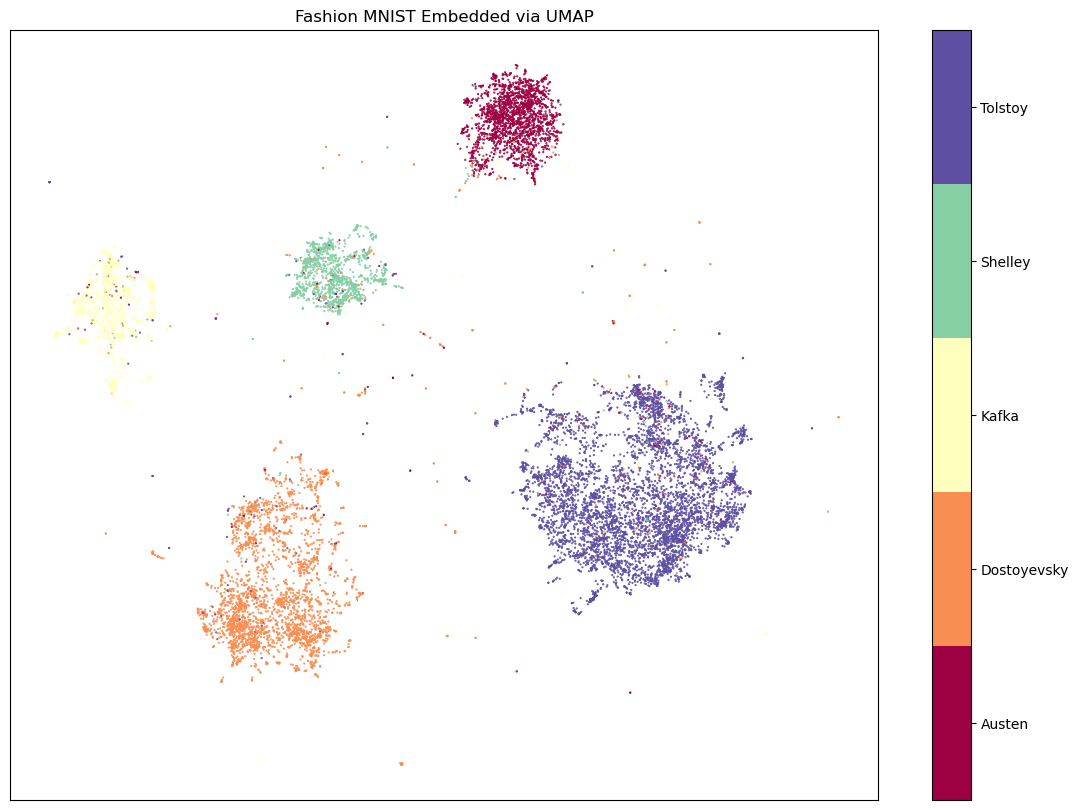

In [55]:
classes = ['Austen', 'Dostoyevsky', 'Kafka', 'Shelley', 'Tolstoy']

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding_train.T, s=0.3, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP')

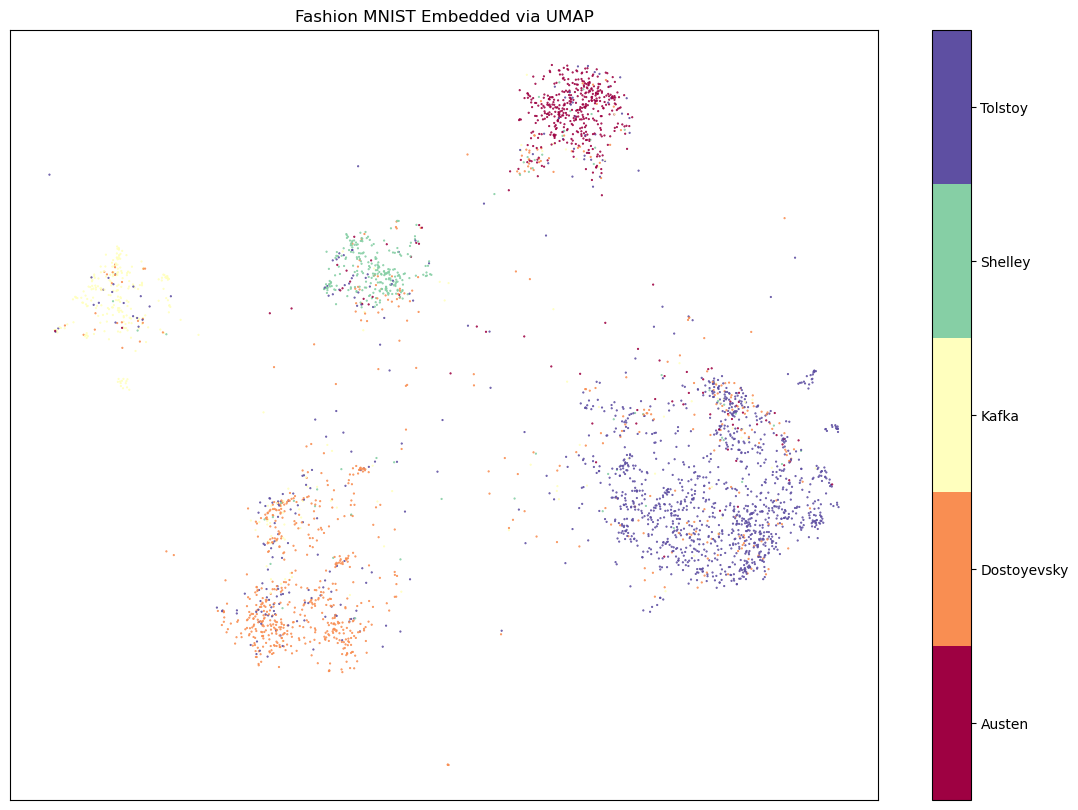

In [56]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding_test.T, s=0.3, c=y_test, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(6)-0.5)
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP');

### K-means

In [57]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [58]:
clusterable_embedding = umap.UMAP(
    n_neighbors=10,
    min_dist=0.0,
    n_components=2,
    random_state=3,
).fit_transform(X_train)

c:\Users\maria\anaconda3\envs\textembedding\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


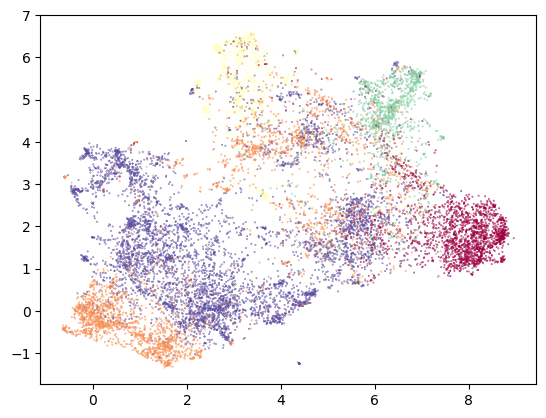

In [59]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=y_train, s=0.1, cmap='Spectral')

In [47]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

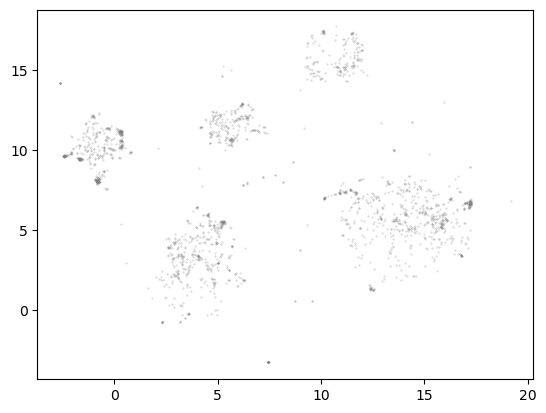

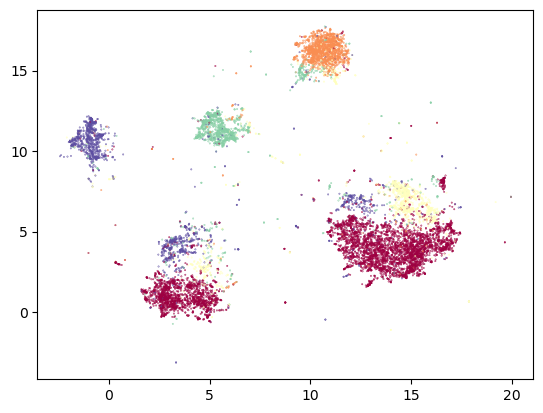

In [65]:
clustered = (labels >= 0)
plt.scatter(embedding_train[~clustered, 0],
            embedding_train[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.show()

plt.scatter(embedding_train[clustered, 0],
            embedding_train[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral')
plt.show()

In [66]:
kmeans_labels = cluster.KMeans(n_clusters=5).fit_predict(X_train)

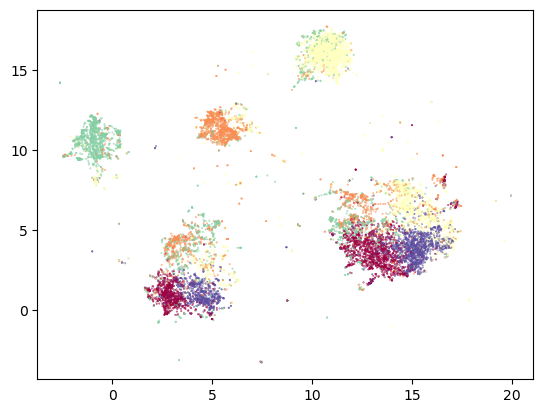

In [67]:
plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')